NAME: __TODO: Naveen Jajapur

# Machine Learning Practice - Asynchronous
## Homework F: Regularization 

### Data set
The dataset is identical to what we used in HW E


### Task
For this assignment you will be exploring **regularization.** Regularization
is a powerful tool in machine learning to impose rational constraints on 
models during the training process to mitigate overfitting to the training 
set and improve model generalization. By including one or more terms within
the cost (error) function to penalize large weights, the learning algorithm will try 
to fit the data while avoiding certain values for the weights that might lead to
overfitting of the training data.


### Objectives
* Use and understand regularization in regression
* Learn to select hyper-parameters to tune model behavior


### Instructions
* All Homework must be individual work.  Do not look at or copy solutions of other students or that are available on the Internet or via LLMs
* Only work in a copy of the file that is from your ~/homework_in/ directory
   + __If you do not use your own copy of this file, then it is an automatic zero on the assignment__
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results.  Note that because we are reusing variables, the order of execution is *really* important.
* Hand-In Procedure
  + Make sure that your notebook has been saved.  You are responsible for ensuring that the copy that you submit is current and complete
  + The name of the file should be the same as what we gave you
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradescope Notebook HWF dropbox


### General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/api/sklearn.linear_model.html)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html)
* [JobLib](https://joblib.readthedocs.io/en/latest/)


In [2]:
# PROVIDED
import pickle as pkl
import pandas as pd
import numpy as np
import os, re, fnmatch, time
import matplotlib.pyplot as plt
import joblib
import copy

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics import make_scorer

# Default figure parameters
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12
                                      
%matplotlib inline

# LOAD DATA

In [3]:
""" PROVIDED: Execute cell
Load the BMI data from all the folds
"""
fname = '/mlp/datasets/bmi/bmi_dataset.pkl'

with open(fname, 'rb') as f:
    bmi = pkl.load(f)
    theta_folds = bmi['theta']
    dtheta_folds = bmi['dtheta']
    ddtheta_folds = bmi['ddtheta']
    torque_folds = bmi['torque']
    time_folds = bmi['time']
    MI_folds = bmi['MI'] 

print("Number of folds:", len(MI_folds))

Number of folds: 20


# Helper Functions

In [4]:
""" PROVIDED
Evaluate the performance of an already trained model

"""

def predict_score_eval(model, X, y, convert_deg=False):
    '''
    
    Compute the model predictions and cooresponding scores.
    PARAMS:
        model: the trained model used to make predicitons
        X: feature data (MxN)
        y: desired output (Mxk)
        convert_deg: Boolean flag to indicate whether rmse should be
            converted from rad to deg
            
    RETURNS:
        mse: mean squared error for each column (k vector)
        rmse: rMSE (k vector)
        fvaf: fraction of variance accounted for metric (k vector)
        preds: predictions made by the model (M x k matrix)
    '''
    # use the model to predict the outputs from the input data
    preds = model.predict(X) 
    

    # Compute VAR/MSE/RMSE
    mse = np.sum(np.square(y - preds), axis=0) / y.shape[0] 
    var = np.var(y, axis=0)

    fvaf = 1 - mse/var 
    
    rmse = np.sqrt(mse) 
    
    if convert_deg:
        rmse = rmse * 180 / np.pi 

    return mse, rmse, fvaf, preds, var




In [5]:
'''
PROVIDED: Execute Cell
'''
def extract_data_set(folds, data):
    '''
    For the data provided, extract only the specified folds and concatenate them together
    
    :param folds: Python list of fold indices to extract
    :param data: Python list of all folds of any number of data fields (e.g., 20 folds 
        of ddtheta and torque)
    
    :return: Tuple of the specific types, containing only the specified folds
    '''
    # For each field in data, extract only the specified folds
    output = [np.concatenate([d[f] for f in folds]) for d in data]
    
    # Convert the list to a tuple
    return tuple(output)

In [6]:
"""
TODO

Construct training, validation and test sets

Training set: used for selecting model parameters
Validation set: used for selecting model hyper-parameters
Test set: used sparingly to evaluate the final models

We are building models to predict shoulder torque
"""
# Extract fold indices for the training, validation and testing sets
trainset_fold_inds = [8] 
validationset_fold_inds = [0,2,4,6] 
testset_fold_inds = [1,3,5,7] 

# Data to predict: Joint torque
predict_folds = torque_folds

# We are focusing on just the shoulder
predict_index = 0

# Combine the folds into singular numpy arrays for each of the Training, Validation and Testing sets
#  Use extract_data_set() above
data = [time_folds, MI_folds, predict_folds]
# Training set
timetrain, Xtrain, ytrain = extract_data_set(trainset_fold_inds, data)# TODO  
# Extract just the predict_index
ytrain = np.squeeze(ytrain[:,predict_index]) 

# Validation set
timeval, Xval, yval = extract_data_set( validationset_fold_inds, data)# TODO
yval = np.squeeze(yval[:,predict_index]) 

# Testing set
timetest, Xtest, ytest = extract_data_set( testset_fold_inds, data)# TODO
ytest = np.squeeze(ytest[:,predict_index]) 


In [7]:
# PROVIDED: Execute Cell

print('Train:', Xtrain.shape, ytrain.shape)
print('Validation:', Xval.shape, yval.shape)
print('Test:', Xtest.shape, ytest.shape)

Train: (1247, 960) (1247,)
Validation: (5597, 960) (5597,)
Test: (4751, 960) (4751,)


## Linear Model

In [30]:
""" 
TODO

Pipeline component object: Estimator and Transformer.

Applies a power transformation to the individual elements of a numpy array.

    Returns a numpy array of the same shape.  For each element x of the array:
        x -> x^exponent

COPY YOUR IMPLEMENTATION FROM HW E
"""
class PowerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, exponent=1):
        """
        Initializes the transformer with an exponent, defaulting to 1.
        """
        self.exponent = exponent
    
    def fit(self, X, y=None):
        """
        This transformer doesn't need to 'fit' anything from the data, 
        so we just return the object itself.
        """
        return self
    
    def transform(self, X):
        """
        Applies the power transformation: raises each element of the input array 
        to the specified exponent.
        """
        
        
        X = np.asarray(X)
        
        # Perform the transformation
        X_transformed = np.power(X, self.exponent)
        
        return X_transformed


In [31]:
""" TODO
Construct and train a model using the training set.  This model is a pipeline:
- Power Transformer.  Use exp=0.5
- Standard Scaler
- Linear Regression

Display the Training set rmse (N-m) and fvaf
"""

model_lnr = Pipeline([
    ("power_transformer",PowerTransformer(exponent=0.5)),
    ("standard_scalar",StandardScaler()),
    ("linear_regression",LinearRegression())
 # TODO
])

model_lnr.fit(Xtrain, ytrain)

# Show the performance of the model with respect to the training set
#  Print FVAF and RMSE (latter in N-m) 
# TODO
mse, rmse, fvaf, pred, var = predict_score_eval(model_lnr,Xtrain,ytrain,convert_deg=True)#TODO
print(fvaf, rmse)

0.9603958119801584 1.9926664862317625


In [32]:
# TODO
# Show model performance with respect to the validation data set
#  Print FVAF and RMSE (latter in N-m) 
mse, rmse, fvaf, pred, var = predict_score_eval(model_lnr,Xval,yval,convert_deg=True)#TODO
print(fvaf, rmse)

0.3198779148475883 8.61540170967413


## Regularized Regression

In [33]:
# TODO

# Create a Lasso model Pipeline:
# - Power Transformer with exp=0.5
# - Standard Scalar
# - Elastic Net with alpha = 0.1

model_regularized = Pipeline([
    ("power_transformer",PowerTransformer(exponent=0.5)),
    ("standard_scalar",StandardScaler()),
    ("elastic_net",ElasticNet(alpha=0.1))
 # TODO
])

# A set of l1_ratio parameter values to try 
l1_ratios = np.logspace(-6, 0, base=10, num=30, endpoint=False)
l1_ratios

array([1.00000000e-06, 1.58489319e-06, 2.51188643e-06, 3.98107171e-06,
       6.30957344e-06, 1.00000000e-05, 1.58489319e-05, 2.51188643e-05,
       3.98107171e-05, 6.30957344e-05, 1.00000000e-04, 1.58489319e-04,
       2.51188643e-04, 3.98107171e-04, 6.30957344e-04, 1.00000000e-03,
       1.58489319e-03, 2.51188643e-03, 3.98107171e-03, 6.30957344e-03,
       1.00000000e-02, 1.58489319e-02, 2.51188643e-02, 3.98107171e-02,
       6.30957344e-02, 1.00000000e-01, 1.58489319e-01, 2.51188643e-01,
       3.98107171e-01, 6.30957344e-01])

In [34]:
# TODO

def hyperparameter_loop(model, Xtrain, ytrain, Xval, yval, l1_ratios, convert_deg=False):
    '''
    Loop over all possible l1 ratios:
    - Set the Lasso model l1_ratio property to the specific l1_ratio
    - Fit model to Xtrain/ytrain
    - Compute rmse (N-m) and FVAF for Xtrain/ytrain and Xval/yval & record these in 
            numpy arrays 
     Return the fvaf amd rmse for both the training and validation sets
    
    :param model: ML model to fit
    :param Xtrain: training set inputs
    :param ytrain: training set desired output
    :param Xval: validation set inputs
    :param yval: validation set desired output
    :param l1_ratios: List of l1_ratio hyper-parameter values to try
    :param convert_deg: Convert from radians to degrees
    
    :return: rmse/fvaf for the training set and validation set, as well as the zero coefficient count
    '''
    rmse_train = np.zeros(l1_ratios.shape)
    rmse_valid = np.zeros(l1_ratios.shape)
    fvaf_train = np.zeros(l1_ratios.shape)
    fvaf_valid = np.zeros(l1_ratios.shape)
    zero_count = np.zeros(l1_ratios.shape)
    
    # Loop over all possible hyperparameter values
    for i, l1_ratio in enumerate(l1_ratios):
        # Copy model
        model_tmp = copy.deepcopy(model)
        
        # Set l1_ratio property of the Lasso model
        # TODO
        model_tmp.set_params(elastic_net__l1_ratio=l1_ratio)
        
        # Fit the model to the training set
        
        model_tmp.fit(Xtrain, ytrain)  # TODO
        
        # Record rmse/fvaf for both training and validation sets
        _, rmse, fvaf, _, _ = predict_score_eval(model_tmp,Xtrain,ytrain,convert_deg=convert_deg)#TODO
        rmse_train[i] = rmse
        fvaf_train[i] = fvaf
        
        _, rmse, fvaf, _, _ = predict_score_eval( model_tmp,Xval,yval,convert_deg=convert_deg)#TODO
        rmse_valid[i] = rmse
        fvaf_valid[i] = fvaf
        
        # Count and the number of model parameters that are exactly zero
        zero_count[i] =  np.sum(model_tmp.named_steps['elastic_net'].coef_ == 0)# TODO
        
        
    # Return training and validation performance arrays
    return rmse_train, fvaf_train, rmse_valid, fvaf_valid, zero_count

In [35]:
# TODO
# Call hyperparameter_loop with the regularized model

rmse_train, fvaf_train, rmse_valid, fvaf_valid, zero_count = hyperparameter_loop(model_regularized, Xtrain, ytrain, Xval, yval,l1_ratios,convert_deg=True) # TODO

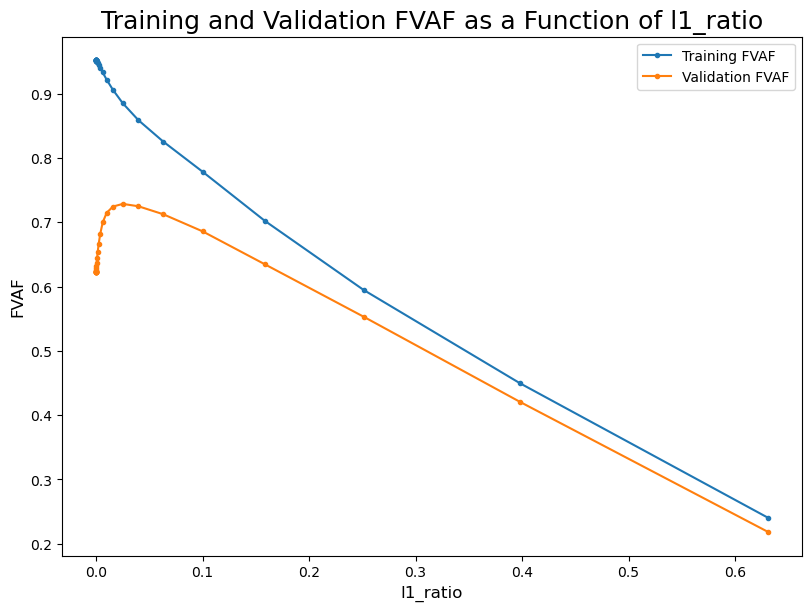

In [36]:
# TODO
# Plot training and validation FVAF as a function of l1_ratio

plt.figure()

plt.plot(l1_ratios, fvaf_train, label='Training FVAF',marker='.')
plt.plot(l1_ratios, fvaf_valid, label='Validation FVAF',marker='.')
plt.xlabel('l1_ratio')
plt.ylabel('FVAF')
plt.legend()
plt.title('Training and Validation FVAF as a Function of l1_ratio')
plt.show()

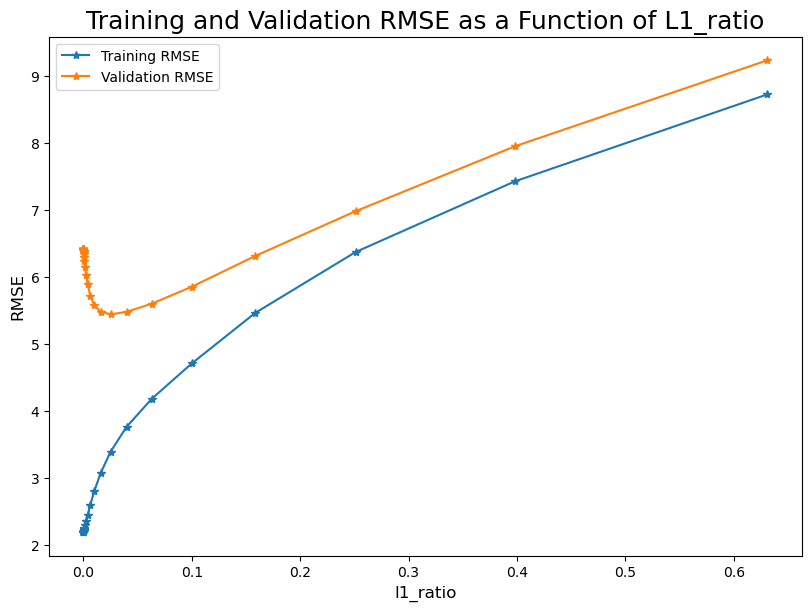

In [37]:
# TODO
# Plot training and validation rmse as a function of l1_ratio

# TODO
plt.figure()
plt.plot(l1_ratios, rmse_train, label='Training RMSE',marker ='*')
plt.plot(l1_ratios, rmse_valid, label='Validation RMSE',marker='*')
plt.xlabel('l1_ratio')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training and Validation RMSE as a Function of L1_ratio')
plt.show()

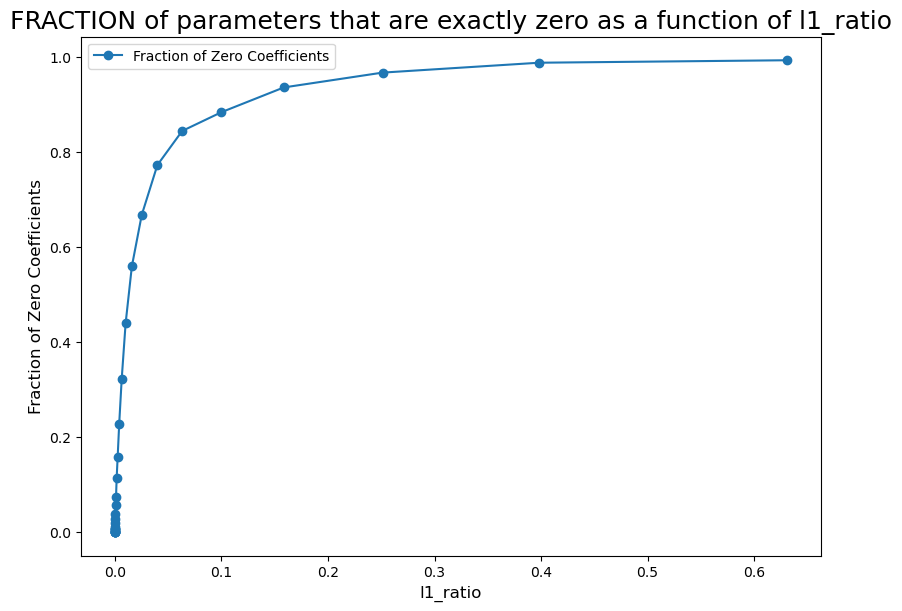

In [38]:
# TODO
# Plot the FRACTION of parameters that are exactly zero as a function of l1_ratio

plt.figure()
plt.plot(l1_ratios, zero_count / Xtrain.shape[1], label='Fraction of Zero Coefficients',marker='o')
plt.xlabel('l1_ratio')
plt.ylabel('Fraction of Zero Coefficients')
plt.legend()
plt.title('FRACTION of parameters that are exactly zero as a function of l1_ratio')
plt.show()
# TODO

In [39]:
# TODO
# Identify and print the index in fvaf_valid that is best
idx_fvaf = np.where(fvaf_valid == np.max(fvaf_valid))[0][0]#TODO
print(f' index in fvaf_valid: {idx_fvaf}')

 index in fvaf_valid: 22


In [40]:
# TODO
# Show the l1_ratio that corresponds to this best model
# TODO
print(f" best model l1_ratio : {l1_ratios[idx_fvaf]}")

 best model l1_ratio : 0.025118864315095822


In [41]:
# TODO
# Identify and print the index in fvaf_rmse that is best
idx_rmse = np.where(rmse_valid == np.min(rmse_valid))[0][0]#TODO
print(f'index in fvaf_rmse : {idx_rmse}')

index in fvaf_rmse : 22


In [42]:
# TODO
# Show the l1_ratio that corresponds to this best model
# TODO
print(f" best model l1_ratio: {l1_ratios[idx_rmse]}")

 best model l1_ratio: 0.025118864315095822


In [43]:
# TODO
# Set the regularized model l1_ratio to the best value with respect to FVAF
#  and fit the model to the training data

# TODO
model_regularized.set_params(elastic_net__l1_ratio=l1_ratios[idx_fvaf])
model_regularized.fit(Xtrain, ytrain)

Pipeline(steps=[('power_transformer', PowerTransformer(exponent=0.5)),
                ('standard_scalar', StandardScaler()),
                ('elastic_net',
                 ElasticNet(alpha=0.1, l1_ratio=0.025118864315095822))])

In [44]:
# TODO
# Compute the predictions for the training data by this model
predtrain =  model_regularized.predict(Xtrain)# TODO


In [45]:
# TODO
# Compute the predictions for the test data by this model
predtest =  model_regularized.predict(Xval)# TODO


# Report the fvaf and rmse for the test data
# TODO
_, rmse, fvaf, _, _ = predict_score_eval(model_regularized,Xtest,ytest,convert_deg=True)#TODO
print(fvaf, rmse)

0.6773078223192847 6.110365990388136


In [46]:
# TODO
# You have already fit the LinearRegression model to the training data
# (above).   Use it to predict arm movement for the test data
preds_lnr = model_lnr.predict(Xtrain) # TODO

In [47]:
# Report the LinearRegression fvaf and rmse for the test data
# TODO
_, rmse, fvaf, _, _ = predict_score_eval( model_lnr,Xtest,ytest,convert_deg=True)# TODO
print(fvaf, rmse)


0.28523926370159447 9.09396647061263


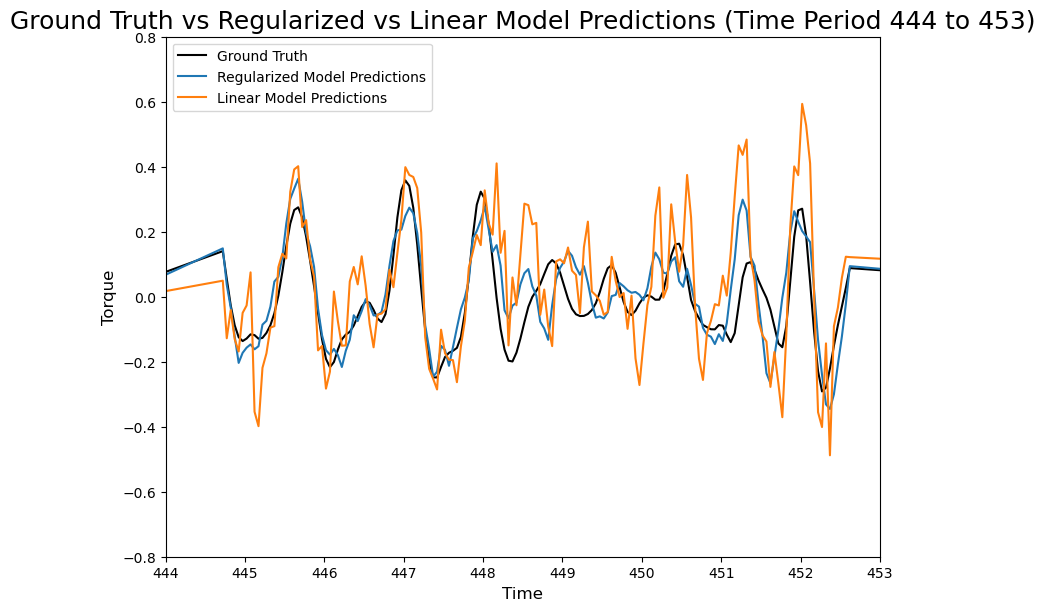

In [48]:
# TODO
# Plot: ground truth, regularized model predictions and the Linear model predictions for 
#  time period 444 to 453

regularised_preds = model_regularized.predict(Xtest)
linear_pred = model_lnr.predict(Xtest)
plt.figure()
# TODO
plt.plot(timetest, ytest, label='Ground Truth',color='black')
plt.plot(timetest, regularised_preds, label='Regularized Model Predictions')
plt.plot(timetest, linear_pred, label='Linear Model Predictions')
plt.xlim((444,453))
plt.ylim((-0.8,0.8))
plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()
plt.title('Ground Truth vs Regularized vs Linear Model Predictions (Time Period 444 to 453)')
plt.show()

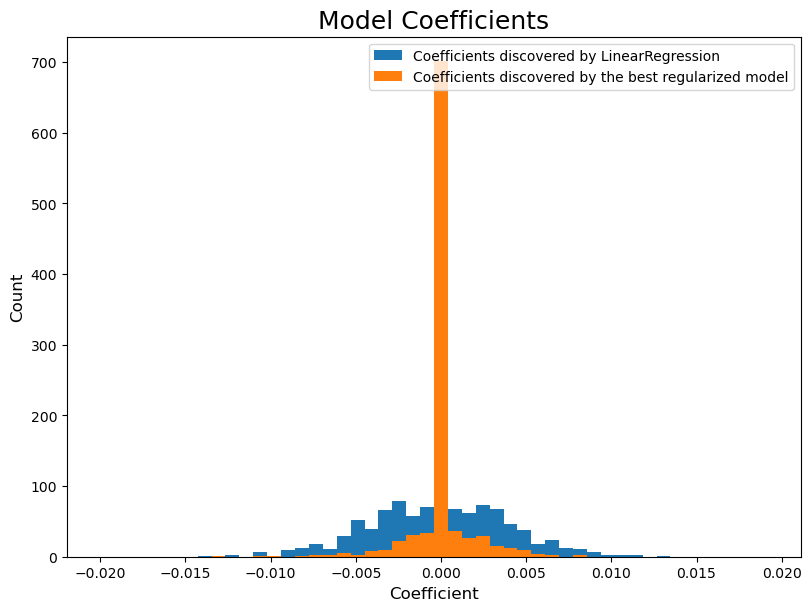

In [49]:
""" TODO: complete implementation
Generate a plot that contains two overlapping histograms:
- Coefficients discovered by LinearRegression
- Coefficients discovered by the best regularized model

"""
nbins = 49
start = -0.02
end = 0.02
incr = (end - start) / nbins
bins = np.arange(start, end, incr)

# When using plt.hist(), use bins=bins.  This will use the exact same bins for
#   both histograms
plt.figure()
#TODO
plt.hist(model_lnr.named_steps['linear_regression'].coef_, bins=bins,  label='Coefficients discovered by LinearRegression')
plt.hist(model_regularized.named_steps['elastic_net'].coef_, bins=bins, label='Coefficients discovered by the best regularized model')
plt.xlabel('Coefficient')
plt.ylabel('Count')
plt.title("Model Coefficients")
plt.legend()


## Reflection
Respond to each of the following questions with short answers.

_Q1. For the simple LinearRegression model, what is the difference in performance between the training and validation sets?  Explain this difference_

**ANS** The Linear Regression model works really well on the training data, with an FVAF of 0.9604 and a low RMSE of 1.9927 N-m. But when it comes to new data, its performance drops a lot, its FVAF goes down to 0.3199, and the RMSE jumps to 8.6154 N-m. This big difference shows that the model has learned the training data too specifically and struggles to handle new data well, meaning it's overfitting.

_Q2. For the RMSE vs l1_ratio curves, describe the difference between the training and validation data sets.  Explain this difference._

**ANS** As the l1_ratio increases, the model continues to perform well on the training data, keeping the RMSE low. However, it struggles with the validation data, leading to a higher RMSE. This widening gap between the training and validation sets indicates that the model is overfitting, it's learning the specifics of the training data but isn't able to generalize effectively to new data.


_Q3.  Referring to the figure showing the Zero Coefficient Count as a function of l1_ratio, describe and then explain the shape of the curve._

**ANS** As l1_ratio increases, more of the model's coefficients are set to zero, meaning the model is simplifying by keeping only the most significant features and discarding the less important ones. This helps prevent overfitting by ensuring the model focuses on the key features, leading to better generalization on new data.


_Q4. What is the best l1_ratio for this combination of data sets?_

**ANS** The best L1_ratio for the given combinatinon of data sets is : {l1_ratios[idx_fvaf]} : 0.020.025118864315095822Q5.


_Q5. How does the performance of the best Regularized Model compare to that of the LinearRegression model with respect to the test data set? Include units._

**ANS** The Regularized Model outperforms the Linear Regression model on the test dataset, with an RMSE of 6.110 N-m compared to 9.094 N-m for Linear Regression, and an FVAF of 0.68 versus 0.29, indicating better accuracy and generalizability.

_Q6. How many non-zero coefficients are there for the best regularized model?_
 
**ANS** There are 319 non-zero coefficients for the regularized model.
Here is the line of code that can be used to get non - zero coefficients.
x = model_regularized.named_steps['elastic_net'].coef_
print(np.sum(x!= 0))


_Q7. Why are the model coefficient distributions different for the LinearRegression and the Lasso models?_

**ANS** Linear Regression assigns a value to every feature, so all features end up contributing to the final model, which means it often has many non-zero coefficients. On the other hand, Lasso uses regularization that helps make the model simpler. It does this by setting the less important features to zero, meaning only the most important features get used in making predictions. This leads to a model that is more focused and easier to interpret because it has fewer, more meaningful features.


_Q8. True or False? The best choice of l1_ratio is the same whether we are optimizing for FVAF or RMSE._

**ANS** True. It is because the idx_fvaf and idx_rmse values are same.


_Q9. Compare and contrast the three joint torque curves in the above figure._

**ANS** The graph plots torque on the y-axis against time on the x-axis, showing how well two models match the actual torque values over a specific period. The Ground Truth curve shows the real torque values, while the Regularized Model predictions follow this trend smoothly, meaning it does a good job of capturing the true pattern. On the other hand, the Linear Model predictions have exaggerated ups and downs, showing that it's overfitting the training data and not generalizing well to new data.


.


